# Google Isolated Sign Language Recognition

Code submitted for group project, DA526, 2023, IITG.

Team Members: Vikky Masih, Pallapu Mohan Krishna, Shania H, Rahul Bhardwaj, Prakhar Kumar Sonkar

(c)2023 Vikky Masih, MFS DS&AI, IITG. Free for educational use.

In [1]:
# !pip install itables

In [2]:
import os
import math
import time
import copy

import numpy as np 
import pandas as pd 

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from itables import init_notebook_mode
import itables.options as itable_opt
from tqdm.notebook import trange, tqdm

In [3]:
# itable_opt.maxBytes=512*1024
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [4]:
# Install dependencies if working on your own desktop
# Not required on Kaggle
#!pip install pyarrow fastparquet

# Environment Variables

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.has_mps else device
print(f"Using {device} device")

if device=="cuda":
    !nvidia-smi

Using cuda device
Fri May 12 22:48:17 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090       WDDM | 00000000:01:00.0  On |                  Off |
|  0%   38C    P8               16W / 450W|    368MiB / 24564MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-------

In [6]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
myDataDir='data/google_asl_data' if not iskaggle else os.path.join("/kaggle","input","asl-signs")
outputDir="data/output" if not iskaggle else "output"
myLabelFile=os.path.join(myDataDir,"train.csv")

# Read metadata and define subset

In [7]:
# Subset of classes used for analysis
animals="bird,bug,cat,cow,dog,fish,frog,hen,mouse,pig".split(",")

# Reading metadata from csv file
T = pd.read_csv(myLabelFile)

# Limiting analysis to defined subset
T=T.loc[T.sign.isin(animals)]
T.reset_index(drop=True, inplace=True)

# Metadata display
T

path  participant_id  \
0      train_landmark_files/26734/817772057.parquet           26734   
1     train_landmark_files/25571/1000210073.parquet           25571   
2     train_landmark_files/53618/2013144557.parquet           53618   
3     train_landmark_files/49445/1339458431.parquet           49445   
4     train_landmark_files/49445/4020597832.parquet           49445   
...                                             ...             ...   
3899  train_landmark_files/49445/2341831773.parquet           49445   
3900   train_landmark_files/22343/817139452.parquet           22343   
3901   train_landmark_files/29302/817209502.parquet           29302   
3902  train_landmark_files/16069/3686985190.parquet           16069   
3903  train_landmark_files/34503/3345486890.parquet           34503   

      sequence_id   sign  
0       817772057    cow  
1      1000210073   bird  
2      2013144557  mouse  
3      1339458431    cow  
4      4020597832    cat  
...           ...    ...  
3899   2341831773    pig  
3900    817139452    dog  
3901    817209502   bird  
3902   3686985190    bug  
3903   3345486890    cat  

[3904 rows x 4 columns]

# Sample data

In [8]:
pd.read_parquet(os.path.join(myDataDir,T.path[0]))

frame            row_id        type  landmark_index         x  \
0          4          4-face-0        face               0  0.542482   
1          4          4-face-1        face               1  0.544677   
2          4          4-face-2        face               2  0.544339   
3          4          4-face-3        face               3  0.536504   
4          4          4-face-4        face               4  0.545293   
...      ...               ...         ...             ...       ...   
24430     48  48-right_hand-16  right_hand              16  0.210042   
24431     48  48-right_hand-17  right_hand              17  0.055936   
24432     48  48-right_hand-18  right_hand              18  0.061224   
24433     48  48-right_hand-19  right_hand              19  0.078015   
24434     48  48-right_hand-20  right_hand              20  0.096678   

              y         z  
0      0.383600 -0.040542  
1      0.355900 -0.065855  
2      0.366788 -0.037111  
3      0.326103 -0.045485  
4      0.346166 -0.068856  
...         ...       ...  
24430  0.570768 -0.134869  
24431  0.486013 -0.078129  
24432  0.430861 -0.129438  
24433  0.409284 -0.143766  
24434  0.393666 -0.141982  

[24435 rows x 7 columns]

# Constants related to the dataset

In [9]:
# number of landmarks per frame (features)
ROWS_PER_FRAME = 543  

# Point cloud groups as per data file
face_indices=np.arange(0,468)
lhand_indices=np.arange(468,489)
pose_indices=np.arange(489,522)
rhand_indices=np.arange(522,543)

# Helper function to read data files

In [10]:
def load_relevant_data_subset(pq_path):
    # Only taking 3D coordinates from parquet data file
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    
    # Reshaping to 3D tensor format (frame_number,features,coordinates)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return torch.tensor(data.astype(np.float32))

# Helper class & function for mini-batches

In [11]:
class CustomDatasetASL(Dataset):
    def __init__(self, file_paths, labels, data_dir, transform=None, target_transform=None):
        self.file_paths=file_paths
        self.labels=labels
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.file_paths[idx]+'.npy')
        data = torch.tensor(np.load(file_path))
        label = self.labels[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

# Generate mini-batch from list with variable length data
def varLength_collate(batch):
    # Sorting by decreasing order of length
    batch=sorted(batch,key=lambda x:x[0].shape[0],reverse=True)
    (data, target) = zip(*batch)
    
    # Packing variable length data
    data_pack = nn.utils.rnn.pack_sequence(data, enforce_sorted=True)
    return data_pack, torch.vstack(target)

# Data and Target transform functions

In [12]:
# One-hot encoding
def target_transform(y,classN):
    y=torch.tensor(y,dtype=torch.int64)
    return torch.zeros(classN, dtype=torch.float).scatter_(dim=0, index=y, value=1)

def data_transform(data):
    # Removing un-necessary dimensions
    dataZ=data.squeeze()
    
    # Normalizing by frame mean and std while ignoring NaN values
    dataZ=(dataZ-dataZ.nanmean(dim=(0,1)))/np.nanstd(dataZ,axis=(0,1))

    # Detecting missing features
    lhand_missing=(dataZ[:,lhand_indices,:].isnan().sum(dim=[1,2]))>0
    rhand_missing=(dataZ[:,rhand_indices,:].isnan().sum(dim=[1,2]))>0
    face_missing=(dataZ[:,face_indices,:].isnan().sum(dim=[1,2]))>0
    handsMissing=lhand_missing&rhand_missing
    face_or_hands_missing=handsMissing|face_missing

    # Filling up missing hand via mirroring other hand about y-axis
    fillMissingRight=np.where((~handsMissing)&(rhand_missing))[0]
    fillMissingLeft=np.where((~handsMissing)&(lhand_missing))[0]
    if len(fillMissingRight)>0:
        dataZ[fillMissingRight[:,np.newaxis],rhand_indices[np.newaxis,:],0]=    \
             -dataZ[fillMissingRight[:,np.newaxis],lhand_indices[np.newaxis,:],0]

        dataZ[fillMissingRight[:,np.newaxis],rhand_indices[np.newaxis,:],1]=    \
             dataZ[fillMissingRight[:,np.newaxis],lhand_indices[np.newaxis,:],1]

        dataZ[fillMissingRight[:,np.newaxis],rhand_indices[np.newaxis,:],2]=    \
             -dataZ[fillMissingRight[:,np.newaxis],lhand_indices[np.newaxis,:],2]
    if len(fillMissingLeft)>0:
        dataZ[fillMissingLeft[:,np.newaxis],lhand_indices[np.newaxis,:],0]=    \
             -dataZ[fillMissingLeft[:,np.newaxis],rhand_indices[np.newaxis,:],0]

        dataZ[fillMissingLeft[:,np.newaxis],lhand_indices[np.newaxis,:],1]=    \
             dataZ[fillMissingLeft[:,np.newaxis],rhand_indices[np.newaxis,:],1]

        dataZ[fillMissingLeft[:,np.newaxis],lhand_indices[np.newaxis,:],2]=    \
             -dataZ[fillMissingLeft[:,np.newaxis],rhand_indices[np.newaxis,:],2]
    
    # Removing frames without face or both-hands
    dataZ=dataZ[~face_or_hands_missing,:,:]
    
    # Replacing NaN(s) with zero
    return torch.tensor(np.nan_to_num(dataZ,0.0)).flatten(1)

# Finding and eliminating useless videos

In [13]:
frames=np.zeros(len(T))
missing=np.zeros(len(T))
badVideo=[]
for i in trange(len(T)):
    filePath=os.path.join(myDataDir,T.path[i])
    filePathT=os.path.join(outputDir,T.path[i]+'.npy')
    if not os.path.exists(filePathT):
        data=load_relevant_data_subset(filePath)
        dataT=data_transform(data)    
        if(dataT.shape[0]>0):
            os.makedirs(os.path.dirname(filePathT), exist_ok=True)
            with open(filePathT, 'wb') as f:
                np.save(f,np.array(dataT),allow_pickle=False)
        else:
            badVideo.append(i)

print(f"Dropping Videos {badVideo}")
T.drop(badVideo,inplace=True)
T.reset_index(drop=True, inplace=True)

  0%|          | 0/3904 [00:00<?, ?it/s]

Dropping Videos [1129, 2025]


# Target and Group IDs

In [14]:
targets=T.loc[:,"sign"].to_list()
uniqueTarget=list(set(targets))
target_id_map=dict((j,i) for i,j in enumerate(uniqueTarget))
targetIDs=np.array(list(map(lambda x:target_id_map[x],targets)))

groups=T.loc[:,"participant_id"].to_list()
uniqueGroup=list(set(groups))
group_id_map=dict((j,i) for i,j in enumerate(uniqueGroup))
groupIDs=np.array(list(map(lambda x:group_id_map[x],groups)))

# Stratified Group K-Fold Cross Validation Split Helper Function

In [15]:
class SGKF_CV_Splits(object):
    def __init__(self,DataIDs,TargetIDs,GroupIDs,TrainSplits=4,TestSplit=5):
        self.count=TrainSplits
        self.DataIDs=DataIDs
        sgkf1 = StratifiedGroupKFold(n_splits=TestSplit)
        sgkf2 = StratifiedGroupKFold(n_splits=TrainSplits)
        
        (self.trainValID,self.testID)=next(sgkf1.split(range(0,len(TargetIDs)), 
                                                       targetIDs, 
                                                       groupIDs))

        self.trainValFolds=sgkf2.split(self.trainValID, 
                                       targetIDs[self.trainValID], 
                                       groupIDs[self.trainValID])
    def __iter__(self):
        return self
    def __next__(self):
        if self.count > 0:
            (t,v)=next(self.trainValFolds)
            trainID=self.trainValID[t]
            valID=self.trainValID[v]
            self.count -= 1
            return self.DataIDs[trainID], self.DataIDs[valID], self.DataIDs[self.testID]
        else:
            raise StopIteration

# Full dataset and dataloader

In [16]:
fullDataset=CustomDatasetASL(\
                             T.path.to_list(), targetIDs, outputDir,\
                             target_transform=lambda x:target_transform(x,len(uniqueTarget))
                            )
fullDataloader=DataLoader(fullDataset, batch_size=10, shuffle=True, collate_fn=varLength_collate)

# Train-Validate-Test Split

In [17]:
for (tr,va,te) in SGKF_CV_Splits(np.arange(0,len(targetIDs)),targetIDs,groupIDs):
    # Custom Dataset(s)
    trainingDataset=CustomDatasetASL(\
                                     T.path[tr].to_list(), targetIDs[tr], outputDir,\
                                     target_transform=lambda x:target_transform(x,len(uniqueTarget))
                                    )
    validationDataset=CustomDatasetASL(\
                                       T.path[va].to_list(), targetIDs[va], outputDir,\
                                       target_transform=lambda x:target_transform(x,len(uniqueTarget))
                                      )
    testDataset=CustomDatasetASL(\
                                 T.path[te].to_list(), targetIDs[te], outputDir,
                                 target_transform=lambda x:target_transform(x,len(uniqueTarget))
                                )
    
    # Dataloader with batch size = 10
    trainDataloader=DataLoader(trainingDataset, batch_size=10, shuffle=True, collate_fn=varLength_collate)
    valDataloader  =DataLoader(validationDataset, batch_size=10, shuffle=True, collate_fn=varLength_collate)
    testDataloader =DataLoader(testDataset, batch_size=10, shuffle=True, collate_fn=varLength_collate)
    break

# LSTM based Neural Netwok

In [18]:
class Network_LSTM(nn.Module):
    def __init__(self,inSize,hiddenSize,outSize,rnnLayers=1,dropout=0):
        super(Network_LSTM, self).__init__()
        self.inSize = inSize
        self.hiddenSize = hiddenSize
        self.outSize = outSize
        self.rnnLayers = rnnLayers
        self.dropout = dropout
        
        # LSTM Layer
        self.rnn = nn.LSTM(inSize,hiddenSize,rnnLayers,batch_first=True,dropout=dropout)
        
        # Fully Connected Layer
        self.fc = nn.Linear(hiddenSize,outSize,bias=False)

    def forward(self, x):
        x, (hiddenState, cellState) = self.rnn(x)
        x = torch.vstack([k[-1,:] for k in nn.utils.rnn.unpack_sequence(x)])
        x = self.fc(x)
        return x

# Helper Class for Hyper-Parameter Grid Search

In [19]:
class nD_Counter:
    def __init__(self, gridLoc=None, start=0, end=-1):
        assert(len(gridLoc)>0)
        self.dims=len(gridLoc)
        self.gridLoc = gridLoc[::-1]
        self.nds = [len(k) for k in self.gridLoc]
        self.pts = math.prod(self.nds)
        self.i = start
        self.start=start
        self.end=end if end>=0 else (self.pts+end+1)
    
    def __len__(self):
        return(self.end-self.start)
 
    def __iter__(self):
        self.ndi = [0]*self.dims
        return self
 
    def __next__(self):
        i = self.i
        if i == self.end:
            raise StopIteration
        rv=[self.gridLoc[k][self.ndi[k]] for k in range(self.dims)][::-1]
        self.i=i+1
        c=1
        for k in range(self.dims):
            self.ndi[k]+=c
            if self.ndi[k]>=self.nds[k]:
                c=math.floor(self.ndi[k]/self.nds[k])
                self.ndi[k]%=self.nds[k]
            else:
                break
        return rv

# Training loop helper function

In [20]:
def train_model_classification(model, 
                dataTrain, 
                dataValidate, 
                optimizer, 
                scheduler=None,
                criterion=torch.nn.CrossEntropyLoss(),
                device='cpu', 
                num_epochs=25):
    startTime = time.time()
    
    numTrain = len(dataTrain.dataset)
    numVal = len(dataValidate.dataset)
    if scheduler is not None:
        schedulerNeedsInput=str(type(scheduler)).find("ReduceLROnPlateau")!=-1

    history=[]
    topModelState = copy.deepcopy(model.state_dict())
    topModelAccuracy = 0.0
    
    model.to(device)
    for epoch in range(num_epochs):
        print('-' * 80)
        print(f'Epoch {epoch+1}/{num_epochs}')

        tic = time.time()
        model.train()
        trainLoss = 0
        trainTruePositives = 0
        for inputs, targets in dataTrain:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                modelOutputs = model(inputs)
                predictedClass = torch.max(modelOutputs, 1)[1]
                loss = criterion(modelOutputs, targets)                
                loss.backward()
                optimizer.step()        
            trainLoss += loss.item() * targets.size(0)
            trainTruePositives += torch.sum(predictedClass == torch.max(targets,1)[1])        
        toc = time.time()
        trainLoss /= numTrain
        trainAccuracy = trainTruePositives.double() / numTrain
        trainTime = toc-tic
        print(f'Training   | Loss: {trainLoss:10.4f} | Accuracy: {trainAccuracy*100:8.4f}% | Elapsed: {trainTime:5.0f}s')

        tic = time.time()
        model.eval()
        valLoss = 0
        valTruePositives = 0
        for inputs, targets in dataValidate:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            with torch.set_grad_enabled(False):
                modelOutputs = model(inputs)
                predictedClass = torch.max(modelOutputs, 1)[1]
                loss = criterion(modelOutputs, targets)               
            valLoss += loss.item() * len(targets)
            valTruePositives += torch.sum(predictedClass == torch.max(targets,1)[1])  
        toc = time.time()
        
        valLoss /= numVal
        valAccuracy = valTruePositives.double() / numVal
        valTime = toc-tic
        print(f'Validation | Loss: {valLoss:10.4f} | Accuracy: {valAccuracy*100:8.4f}% | Elapsed: {valTime:5.0f}s')
        
        if scheduler is not None:
            if schedulerNeedsInput:
                scheduler.step(valLoss)
            else:
                scheduler.step()

        if valAccuracy > topModelAccuracy:
            topModelAccuracy = valAccuracy
            topModelState = copy.deepcopy(model.state_dict())
        history.append([trainLoss,trainAccuracy,trainTime,valLoss,valAccuracy,valTime])
    time_elapsed = time.time() - startTime
    print("="*80)
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best model accuracy: {topModelAccuracy*100.0 : .2f}%')
    print("="*80)
    # load best model weights
    model.load_state_dict(topModelState)
    return model, torch.tensor(history)

# Hyper-parameter grid search

In [21]:
# Hyper-parameter grid definition
grid_hiddenSize=np.logspace(7,9,3,base=2).astype('int')
grid_rnnLayers=[1,2]
grid_L2_norm=np.logspace(-4,-2,3,base=10)

# Cross entropy loss for classification
criterion = torch.nn.CrossEntropyLoss()

# Max number of epochs
num_epochs = 75

# Best Model
bestModel=None
bestModelValAccuracy=None
bestModelHyperParameters=None
bestModelTrainHistory=None

# Training History
trainHistoryAll=[]

count=0

for h_hS,h_rL,h_L2 in nD_Counter([grid_hiddenSize,grid_rnnLayers,grid_L2_norm]):
    print("|\n"*5)
    print("="*80)
    print(f'Hidden Size = {h_hS}')
    print(f'RNN Layers = {h_rL}')
    print(f'L2 Regularization Weight = {h_L2}')
    
    # Model instance
    model=Network_LSTM(inSize=1629,\
                       hiddenSize=h_hS,\
                       outSize=10,\
                       rnnLayers=h_rL).to(device)
    print("-"*80)
    print("RNN Model:")
    print(model)
    
    # Optimize model by changing parameters of the entire model
    optimizer = torch.optim.Adam(model.parameters(),\
                                 weight_decay=h_L2,\
                                 fused=(device=='cuda'))

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,\
                                                           'min',\
                                                           verbose=True)
    
    # Training Loop
    trainedModel, trainHistory = train_model_classification(model, 
                                                        dataTrain=trainDataloader, 
                                                        dataValidate=valDataloader,
                                                        optimizer=optimizer,
                                                        scheduler=scheduler,
                                                        criterion=criterion,
                                                        device=device,
                                                        num_epochs=num_epochs
                                                       )
    
    # Record training history
    trainHistoryAll.append([[h_hS,h_rL,h_L2],trainHistory])
    modelValAccuracy=float(trainHistory[:,4].max())
    
    # Recording best model
    if (bestModelValAccuracy==None) or (bestModelValAccuracy<modelValAccuracy):
        count+=1
        bestModelValAccuracy=modelValAccuracy
        bestModel=trainedModel
        bestModelHyperParameters=[h_hS,h_rL,h_L2]
        bestModelTrainHistory=trainHistory
        torch.save({'State':bestModel.state_dict(),\
                    'HyperParameters':[h_hS,h_rL,h_L2],\
                    'History':trainHistory},
                   os.path.join(outputDir,'BestModel.pt')
                  )

|
|
|
|
|

Hidden Size = 128
RNN Layers = 1
L2 Regularization Weight = 0.0001
--------------------------------------------------------------------------------
RNN Model:
Network_LSTM(
  (rnn): LSTM(1629, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=False)
)
--------------------------------------------------------------------------------
Epoch 1/75
Training   | Loss:     2.0217 | Accuracy:  25.9580% | Elapsed:    12s
Validation | Loss:     1.8810 | Accuracy:  36.1528% | Elapsed:     3s
--------------------------------------------------------------------------------
Epoch 2/75
Training   | Loss:     1.6755 | Accuracy:  42.6040% | Elapsed:     4s
Validation | Loss:     1.7554 | Accuracy:  36.8349% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 3/75
Training   | Loss:     1.4834 | Accuracy:  50.8447% | Elapsed:     4s
Validation | Loss:     1.5957 | Accuracy:  45.2933% | Elapsed:     1s
--------------

Validation | Loss:     0.9143 | Accuracy:  68.3492% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 35/75
Training   | Loss:     0.4437 | Accuracy:  86.6090% | Elapsed:     4s
Validation | Loss:     0.9599 | Accuracy:  69.1678% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 36/75
Training   | Loss:     0.4292 | Accuracy:  87.6803% | Elapsed:     4s
Validation | Loss:     1.0171 | Accuracy:  66.5757% | Elapsed:     1s
Epoch 00036: reducing learning rate of group 0 to 1.0000e-04.
--------------------------------------------------------------------------------
Epoch 37/75
Training   | Loss:     0.3509 | Accuracy:  90.5645% | Elapsed:     4s
Validation | Loss:     0.8588 | Accuracy:  72.1692% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 38/75
Training   | Loss:     0.3258 | Accuracy:  91.5946% | Elapsed:     4s
Valida

Training   | Loss:     0.2388 | Accuracy:  94.6848% | Elapsed:     4s
Validation | Loss:     0.8114 | Accuracy:  74.7613% | Elapsed:     1s
Epoch 00069: reducing learning rate of group 0 to 1.0000e-07.
--------------------------------------------------------------------------------
Epoch 70/75
Training   | Loss:     0.2386 | Accuracy:  94.6848% | Elapsed:     4s
Validation | Loss:     0.8113 | Accuracy:  74.7613% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 71/75
Training   | Loss:     0.2385 | Accuracy:  94.6848% | Elapsed:     4s
Validation | Loss:     0.8114 | Accuracy:  74.7613% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 72/75
Training   | Loss:     0.2385 | Accuracy:  94.6848% | Elapsed:     4s
Validation | Loss:     0.8114 | Accuracy:  74.7613% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 73/75
Traini

Training   | Loss:     0.5432 | Accuracy:  84.6724% | Elapsed:     4s
Validation | Loss:     0.9056 | Accuracy:  69.8499% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 28/75
Training   | Loss:     0.5240 | Accuracy:  85.2081% | Elapsed:     4s
Validation | Loss:     0.9498 | Accuracy:  68.2128% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 29/75
Training   | Loss:     0.5310 | Accuracy:  84.9197% | Elapsed:     4s
Validation | Loss:     0.9401 | Accuracy:  67.8035% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 30/75
Training   | Loss:     0.5135 | Accuracy:  84.5076% | Elapsed:     4s
Validation | Loss:     0.7874 | Accuracy:  70.9413% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 31/75
Training   | Loss:     0.5007 | Accuracy:  85.7849% | Elapsed:     4

Training   | Loss:     0.2956 | Accuracy:  93.9843% | Elapsed:     4s
Validation | Loss:     0.7424 | Accuracy:  74.4884% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 63/75
Training   | Loss:     0.2936 | Accuracy:  93.8195% | Elapsed:     4s
Validation | Loss:     0.7748 | Accuracy:  74.4884% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 64/75
Training   | Loss:     0.2930 | Accuracy:  93.5311% | Elapsed:     4s
Validation | Loss:     0.7301 | Accuracy:  74.7613% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 65/75
Training   | Loss:     0.2875 | Accuracy:  93.7783% | Elapsed:     4s
Validation | Loss:     0.7459 | Accuracy:  74.8977% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 66/75
Training   | Loss:     0.2847 | Accuracy:  94.0667% | Elapsed:     4

Training   | Loss:     1.1291 | Accuracy:  64.9361% | Elapsed:     4s
Validation | Loss:     1.3951 | Accuracy:  52.1146% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 21/75
Training   | Loss:     1.1331 | Accuracy:  64.7301% | Elapsed:     4s
Validation | Loss:     1.3323 | Accuracy:  58.3902% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 22/75
Training   | Loss:     1.1388 | Accuracy:  65.5542% | Elapsed:     4s
Validation | Loss:     1.2856 | Accuracy:  59.3452% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 23/75
Training   | Loss:     1.1052 | Accuracy:  65.5542% | Elapsed:     4s
Validation | Loss:     1.3803 | Accuracy:  53.7517% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 24/75
Training   | Loss:     1.0807 | Accuracy:  66.3782% | Elapsed:     4

Validation | Loss:     1.2426 | Accuracy:  62.3465% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 56/75
Training   | Loss:     1.0378 | Accuracy:  72.3115% | Elapsed:     4s
Validation | Loss:     1.2822 | Accuracy:  58.5266% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 57/75
Training   | Loss:     1.0041 | Accuracy:  71.9819% | Elapsed:     4s
Validation | Loss:     1.3502 | Accuracy:  52.6603% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 58/75
Training   | Loss:     1.0148 | Accuracy:  72.3115% | Elapsed:     4s
Validation | Loss:     1.2703 | Accuracy:  60.5730% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 59/75
Training   | Loss:     1.0087 | Accuracy:  74.2892% | Elapsed:     4s
Validation | Loss:     1.1709 | Accuracy:  67.2578% | Elapsed:     1

Training   | Loss:     0.9963 | Accuracy:  64.8537% | Elapsed:     4s
Validation | Loss:     1.3019 | Accuracy:  56.7531% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 14/75
Training   | Loss:     0.9088 | Accuracy:  69.5097% | Elapsed:     4s
Validation | Loss:     1.2205 | Accuracy:  56.7531% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 15/75
Training   | Loss:     0.9624 | Accuracy:  64.7301% | Elapsed:     4s
Validation | Loss:     1.0427 | Accuracy:  64.5293% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 16/75
Training   | Loss:     0.8423 | Accuracy:  69.9629% | Elapsed:     4s
Validation | Loss:     1.2082 | Accuracy:  57.9809% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 17/75
Training   | Loss:     0.8288 | Accuracy:  70.9930% | Elapsed:     4

Training   | Loss:     0.2736 | Accuracy:  91.5534% | Elapsed:     4s
Validation | Loss:     1.1814 | Accuracy:  69.3042% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 49/75
Training   | Loss:     0.2713 | Accuracy:  91.7594% | Elapsed:     4s
Validation | Loss:     1.1922 | Accuracy:  69.1678% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 50/75
Training   | Loss:     0.2695 | Accuracy:  91.9654% | Elapsed:     4s
Validation | Loss:     1.1943 | Accuracy:  69.1678% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 51/75
Training   | Loss:     0.2678 | Accuracy:  91.9242% | Elapsed:     4s
Validation | Loss:     1.1936 | Accuracy:  68.8950% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 52/75
Training   | Loss:     0.2662 | Accuracy:  91.9654% | Elapsed:     4

Training   | Loss:     1.3937 | Accuracy:  46.6831% | Elapsed:     3s
Validation | Loss:     1.6063 | Accuracy:  41.3370% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 6/75
Training   | Loss:     1.2595 | Accuracy:  52.5752% | Elapsed:     3s
Validation | Loss:     1.6375 | Accuracy:  45.9754% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 7/75
Training   | Loss:     1.1783 | Accuracy:  56.0363% | Elapsed:     3s
Validation | Loss:     1.3021 | Accuracy:  50.8868% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 8/75
Training   | Loss:     1.1793 | Accuracy:  56.9839% | Elapsed:     4s
Validation | Loss:     1.3398 | Accuracy:  51.8417% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 9/75
Training   | Loss:     1.2107 | Accuracy:  54.8002% | Elapsed:     3s
Va

Validation | Loss:     0.9100 | Accuracy:  70.9413% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 41/75
Training   | Loss:     0.5460 | Accuracy:  82.2002% | Elapsed:     4s
Validation | Loss:     1.1437 | Accuracy:  64.2565% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 42/75
Training   | Loss:     0.5431 | Accuracy:  82.9419% | Elapsed:     4s
Validation | Loss:     0.9996 | Accuracy:  71.4870% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 43/75
Training   | Loss:     0.4743 | Accuracy:  83.7660% | Elapsed:     4s
Validation | Loss:     0.8998 | Accuracy:  73.9427% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 44/75
Training   | Loss:     0.5598 | Accuracy:  81.7470% | Elapsed:     4s
Validation | Loss:     0.8414 | Accuracy:  73.8063% | Elapsed:     1

Training   | Loss:     0.1715 | Accuracy:  95.6325% | Elapsed:     4s
Validation | Loss:     1.0321 | Accuracy:  72.7149% | Elapsed:     1s
Training complete in 5m 33s
Best model accuracy:  73.94%
|
|
|
|
|

Hidden Size = 128
RNN Layers = 2
L2 Regularization Weight = 0.01
--------------------------------------------------------------------------------
RNN Model:
Network_LSTM(
  (rnn): LSTM(1629, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=False)
)
--------------------------------------------------------------------------------
Epoch 1/75
Training   | Loss:     1.9839 | Accuracy:  22.9089% | Elapsed:     4s
Validation | Loss:     2.0278 | Accuracy:  23.7381% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 2/75
Training   | Loss:     1.7522 | Accuracy:  33.9514% | Elapsed:     4s
Validation | Loss:     1.8401 | Accuracy:  30.1501% | Elapsed:     1s
-------------------------------------

Training   | Loss:     0.9956 | Accuracy:  64.2769% | Elapsed:     4s
Validation | Loss:     1.3060 | Accuracy:  54.8431% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 34/75
Training   | Loss:     0.9641 | Accuracy:  67.3671% | Elapsed:     4s
Validation | Loss:     1.3930 | Accuracy:  51.9782% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 35/75
Training   | Loss:     1.0369 | Accuracy:  64.3181% | Elapsed:     4s
Validation | Loss:     1.3148 | Accuracy:  52.6603% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 36/75
Training   | Loss:     0.9699 | Accuracy:  66.7491% | Elapsed:     4s
Validation | Loss:     1.2621 | Accuracy:  53.8881% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 37/75
Training   | Loss:     0.9425 | Accuracy:  67.2435% | Elapsed:     4

Validation | Loss:     1.1693 | Accuracy:  59.6180% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 69/75
Training   | Loss:     0.7536 | Accuracy:  75.0309% | Elapsed:     3s
Validation | Loss:     1.2192 | Accuracy:  56.8895% | Elapsed:     1s
Epoch 00069: reducing learning rate of group 0 to 1.0000e-05.
--------------------------------------------------------------------------------
Epoch 70/75
Training   | Loss:     0.7018 | Accuracy:  78.1623% | Elapsed:     4s
Validation | Loss:     1.1737 | Accuracy:  59.4816% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 71/75
Training   | Loss:     0.7026 | Accuracy:  78.2035% | Elapsed:     3s
Validation | Loss:     1.1904 | Accuracy:  58.5266% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 72/75
Training   | Loss:     0.6878 | Accuracy:  78.4508% | Elapsed:     3s
Valida

Training   | Loss:     0.3846 | Accuracy:  89.8640% | Elapsed:     4s
Validation | Loss:     1.0140 | Accuracy:  64.8022% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 27/75
Training   | Loss:     0.3718 | Accuracy:  89.3284% | Elapsed:     4s
Validation | Loss:     0.8581 | Accuracy:  71.0778% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 28/75
Training   | Loss:     0.3597 | Accuracy:  89.4520% | Elapsed:     4s
Validation | Loss:     0.7182 | Accuracy:  77.7626% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 29/75
Training   | Loss:     0.3790 | Accuracy:  88.6279% | Elapsed:     4s
Validation | Loss:     1.0291 | Accuracy:  64.2565% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 30/75
Training   | Loss:     0.3891 | Accuracy:  88.4219% | Elapsed:     4

Training   | Loss:     0.1922 | Accuracy:  95.7149% | Elapsed:     4s
Validation | Loss:     0.7168 | Accuracy:  78.0355% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 62/75
Training   | Loss:     0.1904 | Accuracy:  95.7149% | Elapsed:     4s
Validation | Loss:     0.7158 | Accuracy:  78.3083% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 63/75
Training   | Loss:     0.1885 | Accuracy:  95.9209% | Elapsed:     4s
Validation | Loss:     0.7203 | Accuracy:  78.3083% | Elapsed:     1s
Epoch 00063: reducing learning rate of group 0 to 1.0000e-06.
--------------------------------------------------------------------------------
Epoch 64/75
Training   | Loss:     0.1857 | Accuracy:  95.9621% | Elapsed:     4s
Validation | Loss:     0.7201 | Accuracy:  78.3083% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 65/75
Traini

Validation | Loss:     0.8242 | Accuracy:  73.8063% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 19/75
Training   | Loss:     0.5517 | Accuracy:  84.2604% | Elapsed:     4s
Validation | Loss:     0.7948 | Accuracy:  74.6248% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 20/75
Training   | Loss:     0.5604 | Accuracy:  83.8072% | Elapsed:     4s
Validation | Loss:     0.8245 | Accuracy:  72.0327% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 21/75
Training   | Loss:     0.5434 | Accuracy:  85.2081% | Elapsed:     4s
Validation | Loss:     0.7363 | Accuracy:  75.7162% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 22/75
Training   | Loss:     0.5508 | Accuracy:  83.8484% | Elapsed:     4s
Validation | Loss:     0.8012 | Accuracy:  74.7613% | Elapsed:     1

Validation | Loss:     0.7357 | Accuracy:  74.8977% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 54/75
Training   | Loss:     0.2487 | Accuracy:  94.8496% | Elapsed:     4s
Validation | Loss:     0.7305 | Accuracy:  76.3984% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 55/75
Training   | Loss:     0.2443 | Accuracy:  94.6848% | Elapsed:     4s
Validation | Loss:     0.7025 | Accuracy:  77.6262% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 56/75
Training   | Loss:     0.2435 | Accuracy:  95.0556% | Elapsed:     4s
Validation | Loss:     0.6880 | Accuracy:  78.0355% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 57/75
Training   | Loss:     0.2384 | Accuracy:  95.0144% | Elapsed:     4s
Validation | Loss:     0.7271 | Accuracy:  76.2619% | Elapsed:     1

Training   | Loss:     1.2166 | Accuracy:  60.0330% | Elapsed:     4s
Validation | Loss:     1.4304 | Accuracy:  52.3874% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 12/75
Training   | Loss:     1.2065 | Accuracy:  62.2579% | Elapsed:     4s
Validation | Loss:     1.4300 | Accuracy:  52.2510% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 13/75
Training   | Loss:     1.1729 | Accuracy:  61.8047% | Elapsed:     4s
Validation | Loss:     1.3718 | Accuracy:  51.9782% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 14/75
Training   | Loss:     1.1563 | Accuracy:  63.6176% | Elapsed:     4s
Validation | Loss:     1.3989 | Accuracy:  48.7040% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 15/75
Training   | Loss:     1.1663 | Accuracy:  63.6176% | Elapsed:     4

Validation | Loss:     1.1192 | Accuracy:  69.3042% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 47/75
Training   | Loss:     0.8889 | Accuracy:  75.6489% | Elapsed:     4s
Validation | Loss:     1.2078 | Accuracy:  61.2551% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 48/75
Training   | Loss:     0.8829 | Accuracy:  75.4429% | Elapsed:     4s
Validation | Loss:     1.1289 | Accuracy:  65.8936% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 49/75
Training   | Loss:     0.8836 | Accuracy:  75.4841% | Elapsed:     4s
Validation | Loss:     1.1510 | Accuracy:  67.3943% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 50/75
Training   | Loss:     0.8724 | Accuracy:  77.3383% | Elapsed:     4s
Validation | Loss:     1.2003 | Accuracy:  64.5293% | Elapsed:     1

Training   | Loss:     1.3827 | Accuracy:  47.5072% | Elapsed:     4s
Validation | Loss:     1.8149 | Accuracy:  36.2892% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 5/75
Training   | Loss:     1.3335 | Accuracy:  48.1665% | Elapsed:     4s
Validation | Loss:     1.4791 | Accuracy:  46.7940% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 6/75
Training   | Loss:     1.2239 | Accuracy:  52.8224% | Elapsed:     4s
Validation | Loss:     1.6558 | Accuracy:  38.6085% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 7/75
Training   | Loss:     1.2454 | Accuracy:  52.7400% | Elapsed:     4s
Validation | Loss:     1.3814 | Accuracy:  51.2960% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 8/75
Training   | Loss:     1.1386 | Accuracy:  54.6354% | Elapsed:     4s
Va

Validation | Loss:     1.2440 | Accuracy:  64.6658% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 40/75
Training   | Loss:     0.5068 | Accuracy:  82.9831% | Elapsed:     4s
Validation | Loss:     0.8850 | Accuracy:  71.7599% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 41/75
Training   | Loss:     0.4263 | Accuracy:  85.4141% | Elapsed:     4s
Validation | Loss:     1.0673 | Accuracy:  69.9864% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 42/75
Training   | Loss:     0.4014 | Accuracy:  86.1970% | Elapsed:     4s
Validation | Loss:     1.0977 | Accuracy:  72.3056% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 43/75
Training   | Loss:     0.3514 | Accuracy:  87.7627% | Elapsed:     4s
Validation | Loss:     1.0012 | Accuracy:  72.7149% | Elapsed:     1

Training   | Loss:     0.1119 | Accuracy:  97.1158% | Elapsed:     4s
Validation | Loss:     1.3396 | Accuracy:  72.0327% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 75/75
Training   | Loss:     0.1118 | Accuracy:  97.1158% | Elapsed:     4s
Validation | Loss:     1.3395 | Accuracy:  72.0327% | Elapsed:     1s
Training complete in 5m 26s
Best model accuracy:  73.26%
|
|
|
|
|

Hidden Size = 256
RNN Layers = 2
L2 Regularization Weight = 0.001
--------------------------------------------------------------------------------
RNN Model:
Network_LSTM(
  (rnn): LSTM(1629, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=10, bias=False)
)
--------------------------------------------------------------------------------
Epoch 1/75
Training   | Loss:     1.8701 | Accuracy:  28.4714% | Elapsed:     4s
Validation | Loss:     1.7896 | Accuracy:  29.4679% | Elapsed:     1s
-----------------------------------

Training   | Loss:     0.5444 | Accuracy:  82.9007% | Elapsed:     4s
Validation | Loss:     1.1502 | Accuracy:  66.9850% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 33/75
Training   | Loss:     0.5280 | Accuracy:  83.7660% | Elapsed:     4s
Validation | Loss:     1.1444 | Accuracy:  67.6671% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 34/75
Training   | Loss:     0.5157 | Accuracy:  83.5187% | Elapsed:     3s
Validation | Loss:     1.0763 | Accuracy:  68.8950% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 35/75
Training   | Loss:     0.4983 | Accuracy:  83.9720% | Elapsed:     4s
Validation | Loss:     1.1478 | Accuracy:  66.9850% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 36/75
Training   | Loss:     0.4899 | Accuracy:  84.5900% | Elapsed:     4

Training   | Loss:     0.3046 | Accuracy:  91.3061% | Elapsed:     4s
Validation | Loss:     1.2829 | Accuracy:  69.0314% | Elapsed:     1s
Epoch 00067: reducing learning rate of group 0 to 1.0000e-07.
--------------------------------------------------------------------------------
Epoch 68/75
Training   | Loss:     0.3038 | Accuracy:  91.3473% | Elapsed:     4s
Validation | Loss:     1.2830 | Accuracy:  69.0314% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 69/75
Training   | Loss:     0.3038 | Accuracy:  91.3473% | Elapsed:     4s
Validation | Loss:     1.2830 | Accuracy:  69.0314% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 70/75
Training   | Loss:     0.3037 | Accuracy:  91.3473% | Elapsed:     4s
Validation | Loss:     1.2831 | Accuracy:  69.0314% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 71/75
Traini

Training   | Loss:     1.1434 | Accuracy:  59.9506% | Elapsed:     4s
Validation | Loss:     1.4374 | Accuracy:  48.4311% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 26/75
Training   | Loss:     1.1994 | Accuracy:  58.0140% | Elapsed:     3s
Validation | Loss:     1.5520 | Accuracy:  47.0668% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 27/75
Training   | Loss:     1.2815 | Accuracy:  54.5529% | Elapsed:     4s
Validation | Loss:     1.3356 | Accuracy:  53.8881% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 28/75
Training   | Loss:     1.1647 | Accuracy:  57.8904% | Elapsed:     4s
Validation | Loss:     1.4201 | Accuracy:  50.8868% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 29/75
Training   | Loss:     1.1452 | Accuracy:  59.2501% | Elapsed:     4

Training   | Loss:     0.8035 | Accuracy:  73.3004% | Elapsed:     4s
Validation | Loss:     1.1929 | Accuracy:  58.2538% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 61/75
Training   | Loss:     0.7951 | Accuracy:  73.2180% | Elapsed:     4s
Validation | Loss:     1.1574 | Accuracy:  61.1187% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 62/75
Training   | Loss:     0.7830 | Accuracy:  73.0944% | Elapsed:     4s
Validation | Loss:     1.1691 | Accuracy:  59.3452% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 63/75
Training   | Loss:     0.7646 | Accuracy:  74.4129% | Elapsed:     4s
Validation | Loss:     1.0714 | Accuracy:  63.8472% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 64/75
Training   | Loss:     0.8175 | Accuracy:  70.1277% | Elapsed:     3

Training   | Loss:     0.5511 | Accuracy:  82.6947% | Elapsed:     4s
Validation | Loss:     0.8531 | Accuracy:  72.5784% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 19/75
Training   | Loss:     0.5308 | Accuracy:  83.7660% | Elapsed:     4s
Validation | Loss:     0.9286 | Accuracy:  66.5757% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 20/75
Training   | Loss:     0.5381 | Accuracy:  84.0132% | Elapsed:     4s
Validation | Loss:     0.9414 | Accuracy:  68.8950% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 21/75
Training   | Loss:     0.4926 | Accuracy:  84.9609% | Elapsed:     4s
Validation | Loss:     1.0895 | Accuracy:  65.3479% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 22/75
Training   | Loss:     0.4639 | Accuracy:  86.0321% | Elapsed:     3

Training   | Loss:     0.1676 | Accuracy:  96.1681% | Elapsed:     3s
Validation | Loss:     0.7571 | Accuracy:  74.6248% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 54/75
Training   | Loss:     0.1642 | Accuracy:  96.5389% | Elapsed:     3s
Validation | Loss:     0.7494 | Accuracy:  74.7613% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 55/75
Training   | Loss:     0.1630 | Accuracy:  96.7450% | Elapsed:     3s
Validation | Loss:     0.7556 | Accuracy:  75.0341% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 56/75
Training   | Loss:     0.1619 | Accuracy:  96.7450% | Elapsed:     3s
Validation | Loss:     0.7584 | Accuracy:  74.6248% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 57/75
Training   | Loss:     0.1608 | Accuracy:  96.7450% | Elapsed:     3

Validation | Loss:     1.1107 | Accuracy:  64.1201% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 11/75
Training   | Loss:     0.7976 | Accuracy:  75.6489% | Elapsed:     3s
Validation | Loss:     1.0077 | Accuracy:  65.6207% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 12/75
Training   | Loss:     0.7681 | Accuracy:  76.7614% | Elapsed:     3s
Validation | Loss:     1.0868 | Accuracy:  62.4829% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 13/75
Training   | Loss:     0.7381 | Accuracy:  77.2559% | Elapsed:     3s
Validation | Loss:     1.0390 | Accuracy:  65.6207% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 14/75
Training   | Loss:     0.7663 | Accuracy:  75.8962% | Elapsed:     3s
Validation | Loss:     1.1596 | Accuracy:  61.9372% | Elapsed:     1

Training   | Loss:     0.4962 | Accuracy:  85.5377% | Elapsed:     3s
Validation | Loss:     0.8949 | Accuracy:  71.7599% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 47/75
Training   | Loss:     0.5059 | Accuracy:  85.6201% | Elapsed:     3s
Validation | Loss:     0.8800 | Accuracy:  70.6685% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 48/75
Training   | Loss:     0.5474 | Accuracy:  84.1368% | Elapsed:     3s
Validation | Loss:     0.8919 | Accuracy:  70.3956% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 49/75
Training   | Loss:     0.5414 | Accuracy:  83.9720% | Elapsed:     3s
Validation | Loss:     0.9044 | Accuracy:  67.2578% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 50/75
Training   | Loss:     0.5688 | Accuracy:  82.9419% | Elapsed:     3

Training   | Loss:     1.5909 | Accuracy:  41.8212% | Elapsed:     3s
Validation | Loss:     1.6631 | Accuracy:  38.1992% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 4/75
Training   | Loss:     1.4945 | Accuracy:  47.3012% | Elapsed:     3s
Validation | Loss:     1.7012 | Accuracy:  41.4734% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 5/75
Training   | Loss:     1.4437 | Accuracy:  49.1965% | Elapsed:     3s
Validation | Loss:     1.7698 | Accuracy:  35.8799% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 6/75
Training   | Loss:     1.4220 | Accuracy:  49.9382% | Elapsed:     3s
Validation | Loss:     1.5486 | Accuracy:  49.2497% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 7/75
Training   | Loss:     1.3530 | Accuracy:  52.0808% | Elapsed:     4s
Va

Validation | Loss:     1.2292 | Accuracy:  58.9359% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 39/75
Training   | Loss:     0.9677 | Accuracy:  73.0944% | Elapsed:     4s
Validation | Loss:     1.3411 | Accuracy:  51.8417% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 40/75
Training   | Loss:     0.9921 | Accuracy:  72.0231% | Elapsed:     4s
Validation | Loss:     1.1831 | Accuracy:  65.2115% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 41/75
Training   | Loss:     0.9763 | Accuracy:  71.8995% | Elapsed:     4s
Validation | Loss:     1.2235 | Accuracy:  61.6644% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 42/75
Training   | Loss:     0.9542 | Accuracy:  72.7235% | Elapsed:     4s
Validation | Loss:     1.2514 | Accuracy:  60.7094% | Elapsed:     1

Validation | Loss:     1.0600 | Accuracy:  72.0327% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 74/75
Training   | Loss:     0.7602 | Accuracy:  81.9530% | Elapsed:     3s
Validation | Loss:     1.0180 | Accuracy:  70.3956% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 75/75
Training   | Loss:     0.7531 | Accuracy:  81.7470% | Elapsed:     3s
Validation | Loss:     1.0295 | Accuracy:  71.4870% | Elapsed:     1s
Training complete in 5m 11s
Best model accuracy:  72.03%
|
|
|
|
|

Hidden Size = 512
RNN Layers = 2
L2 Regularization Weight = 0.0001
--------------------------------------------------------------------------------
RNN Model:
Network_LSTM(
  (rnn): LSTM(1629, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=10, bias=False)
)
--------------------------------------------------------------------------------
Epoch 1/75
Training   

Training   | Loss:     0.4061 | Accuracy:  85.9497% | Elapsed:     4s
Validation | Loss:     0.8478 | Accuracy:  73.2606% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 32/75
Training   | Loss:     0.3948 | Accuracy:  87.1034% | Elapsed:     4s
Validation | Loss:     1.0497 | Accuracy:  70.6685% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 33/75
Training   | Loss:     0.3606 | Accuracy:  87.5567% | Elapsed:     4s
Validation | Loss:     0.9952 | Accuracy:  73.8063% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 34/75
Training   | Loss:     0.3849 | Accuracy:  86.9798% | Elapsed:     4s
Validation | Loss:     0.8774 | Accuracy:  74.0791% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 35/75
Training   | Loss:     0.3785 | Accuracy:  87.3506% | Elapsed:     4

Training   | Loss:     0.0597 | Accuracy:  98.5991% | Elapsed:     4s
Validation | Loss:     1.2562 | Accuracy:  73.9427% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 67/75
Training   | Loss:     0.0589 | Accuracy:  98.5579% | Elapsed:     4s
Validation | Loss:     1.2648 | Accuracy:  74.0791% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 68/75
Training   | Loss:     0.0578 | Accuracy:  98.5991% | Elapsed:     4s
Validation | Loss:     1.2654 | Accuracy:  74.3520% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 69/75
Training   | Loss:     0.0568 | Accuracy:  98.6815% | Elapsed:     4s
Validation | Loss:     1.2797 | Accuracy:  74.3520% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 70/75
Training   | Loss:     0.0558 | Accuracy:  98.6815% | Elapsed:     4

Training   | Loss:     0.7256 | Accuracy:  75.8550% | Elapsed:     4s
Validation | Loss:     1.1596 | Accuracy:  57.2988% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 25/75
Training   | Loss:     0.7221 | Accuracy:  74.6601% | Elapsed:     4s
Validation | Loss:     1.1370 | Accuracy:  61.6644% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 26/75
Training   | Loss:     0.6168 | Accuracy:  78.9040% | Elapsed:     4s
Validation | Loss:     0.9997 | Accuracy:  69.9864% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 27/75
Training   | Loss:     0.5700 | Accuracy:  80.4285% | Elapsed:     4s
Validation | Loss:     1.1602 | Accuracy:  64.5293% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 28/75
Training   | Loss:     0.7299 | Accuracy:  74.3304% | Elapsed:     4

Training   | Loss:     0.3142 | Accuracy:  89.6992% | Elapsed:     4s
Validation | Loss:     0.9924 | Accuracy:  71.6235% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 60/75
Training   | Loss:     0.2971 | Accuracy:  90.6057% | Elapsed:     4s
Validation | Loss:     0.9024 | Accuracy:  73.1241% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 61/75
Training   | Loss:     0.2944 | Accuracy:  90.7293% | Elapsed:     4s
Validation | Loss:     0.9837 | Accuracy:  73.1241% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 62/75
Training   | Loss:     0.2855 | Accuracy:  90.9353% | Elapsed:     4s
Validation | Loss:     0.9347 | Accuracy:  74.2156% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 63/75
Training   | Loss:     0.2815 | Accuracy:  91.1001% | Elapsed:     4

Validation | Loss:     1.3482 | Accuracy:  49.6589% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 17/75
Training   | Loss:     1.1375 | Accuracy:  59.1677% | Elapsed:     4s
Validation | Loss:     1.3008 | Accuracy:  49.2497% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 18/75
Training   | Loss:     1.1096 | Accuracy:  60.4862% | Elapsed:     4s
Validation | Loss:     1.3237 | Accuracy:  53.0696% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 19/75
Training   | Loss:     1.0795 | Accuracy:  62.2167% | Elapsed:     4s
Validation | Loss:     1.1860 | Accuracy:  54.7067% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 20/75
Training   | Loss:     1.7980 | Accuracy:  33.1273% | Elapsed:     4s
Validation | Loss:     1.9526 | Accuracy:  27.6944% | Elapsed:     1

Validation | Loss:     1.1382 | Accuracy:  62.7558% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 52/75
Training   | Loss:     0.7447 | Accuracy:  75.8550% | Elapsed:     4s
Validation | Loss:     1.1504 | Accuracy:  62.3465% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 53/75
Training   | Loss:     0.7284 | Accuracy:  76.8026% | Elapsed:     4s
Validation | Loss:     1.1968 | Accuracy:  59.0723% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 54/75
Training   | Loss:     0.7251 | Accuracy:  76.4730% | Elapsed:     4s
Validation | Loss:     1.0512 | Accuracy:  63.5744% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 55/75
Training   | Loss:     0.7114 | Accuracy:  77.7915% | Elapsed:     4s
Validation | Loss:     1.0782 | Accuracy:  64.5293% | Elapsed:     1

# Hyper-parameter Grid Search Details

In [29]:
d=[]
for hp,th in trainHistoryAll:
    locBest=th[:,4].argmax()
    maxValAccuracy=float(th[locBest,4])
    valLoss=float(th[locBest,3])
    d.append([hp[0],hp[1],hp[2],valLoss,maxValAccuracy])
    
columns=['Hidden_Size','RNN_Layers','L2_Reg_Weight','Val_Loss','Val_Accuracy']
df = pd.DataFrame(d, columns=columns)
df

Hidden_Size  RNN_Layers  L2_Reg_Weight  Val_Loss  Val_Accuracy
0           128           1         0.0001  0.787221      0.762619
1           128           1         0.0010  0.756598      0.759891
2           128           1         0.0100  1.036203      0.712142
3           128           2         0.0001  0.979854      0.713506
4           128           2         0.0010  0.899766      0.739427
5           128           2         0.0100  1.134686      0.612551
6           256           1         0.0001  0.716525      0.784447
7           256           1         0.0010  0.673652      0.796726
8           256           1         0.0100  1.043928      0.702592
9           256           2         0.0001  0.936982      0.732606
10          256           2         0.0010  1.236567      0.693042
11          256           2         0.0100  1.030807      0.657572
12          512           1         0.0001  0.755592      0.750341
13          512           1         0.0010  0.779162      0.738063
14          512           1         0.0100  1.059967      0.720327
15          512           2         0.0001  1.022993      0.759891
16          512           2         0.0010  0.901631      0.755798
17          512           2         0.0100  1.055190      0.660300

# Best Trial Hyper-parameters

In [27]:
print("Best Trial Hyper-parameters:")
print(f'    Hidden Size = {bestModelHyperParameters[0]}')
print(f'    RNN Layers = {bestModelHyperParameters[1]}')
print(f'    L2 Regularization Weight = {bestModelHyperParameters[2]}')

Best Trial Hyper-parameters:
    Hidden Size = 256
    RNN Layers = 1
    L2 Regularization Weight = 0.001


# Best Trial Training Accuracy History

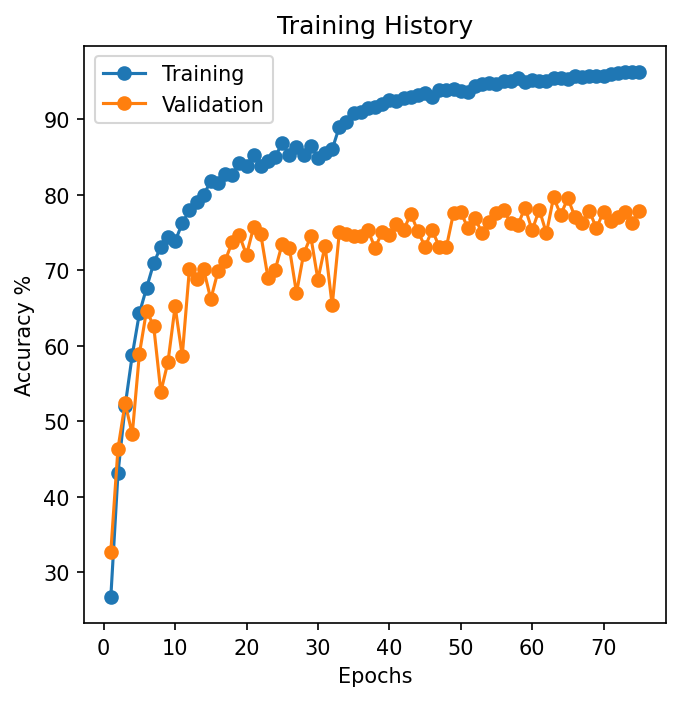

In [22]:
figure = plt.figure(figsize=(5, 5),dpi=150)
plt.plot(range(1,bestModelTrainHistory.size(0)+1), bestModelTrainHistory[:,[1,4]]*100.0,"o-")
plt.legend(["Training","Validation"])
plt.title("Training History")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

# Best Trial Test Accuracy

In [23]:
bestModel.eval()
testLoss = 0
testTruePositives = 0
testN=0
predicted=[]
actual=[]
for inputs, targets in testDataloader:
    inputs = inputs.to(device)
    targets = targets.to(device)

    with torch.set_grad_enabled(False):
        modelOutputs = bestModel(inputs)
        predictedClass = torch.max(modelOutputs, 1)[1]
        loss = torch.nn.CrossEntropyLoss()(modelOutputs, torch.max(targets,1)[1])               
    testLoss += loss.item() * len(targets)
    testN += len(targets)
    predicted+=predictedClass.tolist()
    actual+=torch.max(targets,1)[1].tolist()
    testTruePositives += torch.sum(predictedClass == torch.max(targets,1)[1])  

testLoss /= testN
testAccuracy = testTruePositives.double() / testN

print(f'Test Data | Loss: {testLoss:10.4f} Accuracy: {testAccuracy*100:10.4f}%')

Test Data | Loss:     0.4544 Accuracy:    85.5795%


# Best Trial Test Confusion Matrix

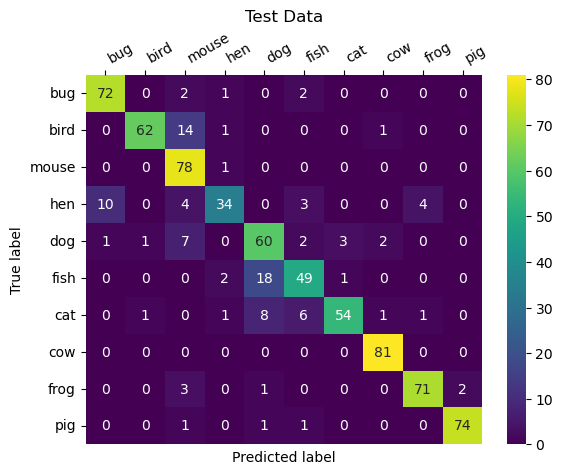

In [24]:
CM=confusion_matrix(actual, predicted)
class_names=[k for k in target_id_map.keys()]
df_cm = pd.DataFrame(CM, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='left')
heatmap.xaxis.tick_top()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Test Data")
plt.show()